### Imports 

In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

#### Mount your google drive so you can save model checkpoints, and report your test results on the final best model after hyperparameter tuning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [3]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [5]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [6]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [7]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
#test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [8]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader, model_name='temp'):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):

        # TODO : Set the model to train mode 
        model.train()       

        # TODO: Loop over the training set 
        n_loss = 0.0
        n_correct = 0
        n_samples = 0
        for i, (inputs, targets) in enumerate(train_loader):

            # TODO: Put the inputs and targets on the write device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # TODO: Feed forward to get the logits
            logits = model(inputs)

            # TODO: Compute the loss and accuracy
            loss = criterion(logits, targets)
            predictions = torch.max(logits, dim=1)[1]
            correct = (predictions == targets).sum().item()

            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()

            # TODO: Update params
            optimizer.step()
            
            # TODO: Keep track of accuracy and loss
            n_loss += loss.item()
            n_correct += correct
            n_samples += targets.size()[0]
        train_losses.append(n_loss/n_samples)
        train_accuracies.append(n_correct/n_samples)

        
        # TODO: Switch the model to eval mode
        model.eval()


        with torch.no_grad():
            # TODO: Loop over the validation set 
            n_loss = 0.0
            n_correct = 0
            n_samples = 0
            for i, (inputs, targets) in enumerate(val_loader):

                # TODO: Put the inputs and targets on the write device
                inputs = inputs.to(device)
                targets = targets.to(device)
            
                # TODO: Feed forward to get the logits
                logits = model(inputs)

                # TODO: Compute the loss and accuracy
                loss = criterion(logits, targets)
                predictions = torch.max(logits, dim=1)[1]
                correct = (predictions == targets).sum().item()

                # TODO: Keep track of accuracy and loss
                n_loss += loss.item()
                n_correct += correct
                n_samples += targets.size()[0]
            val_losses.append(n_loss/n_samples)
            val_accuracies.append(n_correct/n_samples)

        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          my_drive_path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2'
          torch.save(
              {
               'accuracy': best_val,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'epoch_number': t,
              },
              f'{my_drive_path}/results/Q2/{model_name}.pt'
          )
          
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

In [9]:
# ploting methods
def plot_learning_curve(results, title=None):
    train_losses, train_accuracies, val_losses, val_accuracies = results
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    ax[0].plot(train_losses)
    ax[0].plot(val_losses)
    ax[0].legend(['train_loss', 'val_loss'],fontsize=14)
    ax[0].set_title('Loss',fontsize=18)
    ax[0].grid()

    ax[1].plot(train_accuracies)
    ax[1].plot(val_accuracies)
    ax[1].legend(['train_acc', 'val_acc'],fontsize=14)
    ax[1].set_title('Accuracy',fontsize=18)
    ax[1].grid()
    if title:
        fig.suptitle(title,fontsize=18)
    plt.show()

def compare_learning_curves(results1, results2, title=None):
    model1, (train_losses1, train_accuracies1, val_losses1, val_accuracies1) = results1
    model2, (train_losses2, train_accuracies2, val_losses2, val_accuracies2) = results2
    fig, ax = plt.subplots(1,2, figsize=(20,5))

    ax[0].plot(train_losses1, label=f'{model1}: train_loss', c='tab:blue')
    ax[0].plot(val_losses1,ls=':', label=f'{model1}: val_loss', c='tab:green')
    ax[0].plot(train_losses2, label=f'{model2}: train_loss', c='tab:red')
    ax[0].plot(val_losses2,ls=':', label=f'{model2}: val_loss', c='tab:orange')
    ax[0].legend(fontsize=12)
    ax[0].set_title('Loss',fontsize=18)
    ax[0].grid()

    ax[1].plot(train_accuracies1, label=f'{model1}: train_acc', c='tab:blue')
    ax[1].plot(val_accuracies1,ls=':', label=f'{model1}: val_acc', c='tab:green')
    ax[1].plot(train_accuracies2, label=f'{model2}: train_acc', c='tab:red')
    ax[1].plot(val_accuracies2,ls=':', label=f'{model2}: val_acc', c='tab:orange')
    ax[1].legend(fontsize=12)
    ax[1].set_title('Accuracy',fontsize=18)
    ax[1].grid()
    if title:
        fig.suptitle(title,fontsize=18)
    plt.show()

### Q 2.2 Shallow convolutional network. 

In [10]:
class View(nn.Module):
    def __init__(self, shape):
      super().__init__()
      self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [11]:

ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [12]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        """

        Parameters
        ----------
        input_channels : Number of input channels
        num_classes : Number of classes for the final prediction 
        """
        
        # TODO
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=8)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        """

        Parameters
        ----------
        x

        Returns
        -------
        output : Result after running through the model
        """
        
        # TODO
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        x = self.fc(x.view(-1, 256))
        return x
        

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [ ]:
# TODO : Initialize the model and cast to correct device
shallow_model = ShallowConvnet(3, 10).to(device)

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(shallow_model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
shallow_model_results = train_loop(shallow_model, criterion, optimizer,  train_loader, val_loader, model_name='shallow')

[EPOCH]: 0, [TRAIN LOSS]: 1.851603, [TRAIN ACCURACY]: 0.335
[EPOCH]: 0, [VAL LOSS]: 1.532501, [VAL ACCURACY]: 0.440 

[EPOCH]: 1, [TRAIN LOSS]: 1.431537, [TRAIN ACCURACY]: 0.490
[EPOCH]: 1, [VAL LOSS]: 1.225815, [VAL ACCURACY]: 0.568 

[EPOCH]: 2, [TRAIN LOSS]: 1.208518, [TRAIN ACCURACY]: 0.576
[EPOCH]: 2, [VAL LOSS]: 1.131650, [VAL ACCURACY]: 0.594 

[EPOCH]: 3, [TRAIN LOSS]: 1.027578, [TRAIN ACCURACY]: 0.644
[EPOCH]: 3, [VAL LOSS]: 0.964123, [VAL ACCURACY]: 0.669 

[EPOCH]: 4, [TRAIN LOSS]: 0.892479, [TRAIN ACCURACY]: 0.691
[EPOCH]: 4, [VAL LOSS]: 0.855949, [VAL ACCURACY]: 0.707 

[EPOCH]: 5, [TRAIN LOSS]: 0.786377, [TRAIN ACCURACY]: 0.729
[EPOCH]: 5, [VAL LOSS]: 0.971999, [VAL ACCURACY]: 0.670 

[EPOCH]: 6, [TRAIN LOSS]: 0.688203, [TRAIN ACCURACY]: 0.763
[EPOCH]: 6, [VAL LOSS]: 0.836953, [VAL ACCURACY]: 0.719 

[EPOCH]: 7, [TRAIN LOSS]: 0.653919, [TRAIN ACCURACY]: 0.777
[EPOCH]: 7, [VAL LOSS]: 0.802893, [VAL ACCURACY]: 0.729 

[EPOCH]: 8, [TRAIN LOSS]: 0.537930, [TRAIN ACCURACY]: 0.

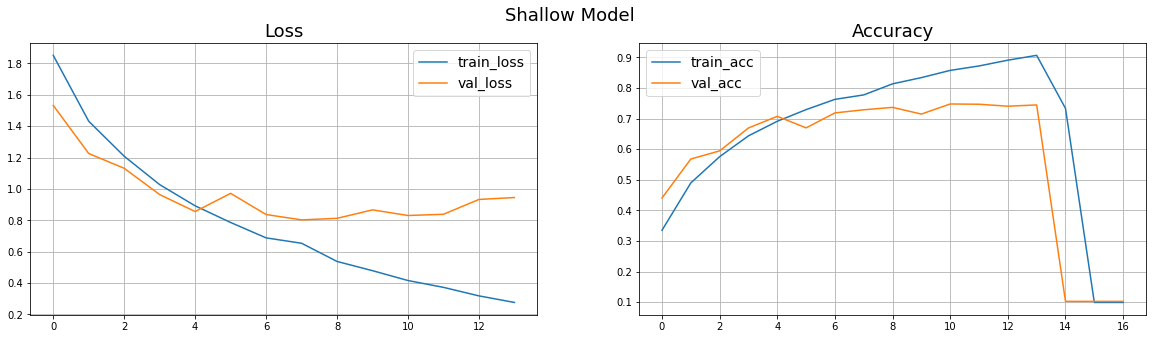

In [ ]:
plot_learning_curve(shallow_model_results, title='Shallow Model')

### Q2.4 Simple convolution network - 

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. Each convolution layer should be followed by a relu non-linearity. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer that halves the resolution of the image. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [13]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        # TODO
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=5, padding=2)
        self.block1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool_halve = nn.MaxPool2d(kernel_size=2)
        # self.pool_final = nn.MaxPool2d(kernel_size=8)
        self.linear = nn.Linear(256, num_classes, bias=True)

    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        x = self.relu(self.conv1(x))

        # HINT: block of 3 conv 
        x = self.block1(x)
        x = self.pool_halve(x)

        # HINT : block of 3 conv 
        x = self.block2(x)
        x = self.pool_halve(x)

        # HINT: block of 3 conv 
        x = self.block3(x)
        
        # x = self.pool_final(x) # Final max pool
        x = torch.max(torch.max(x, dim=-1)[0], dim=-1)[0] # Generic final max pool, will generate 1x1 no matter input size

        # HINT: projection 
        output = self.linear(x.view(-1,256))
        
        return output

In [ ]:
# TODO : Initialize the model and cast to correct device
simple_model = SimpleConvnet(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(simple_model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
simple_model_results = train_loop(simple_model, criterion, optimizer, train_loader, val_loader, model_name='simple')

[EPOCH]: 0, [TRAIN LOSS]: 2.303001, [TRAIN ACCURACY]: 0.096
[EPOCH]: 0, [VAL LOSS]: 2.302702, [VAL ACCURACY]: 0.101 

[EPOCH]: 1, [TRAIN LOSS]: 2.302416, [TRAIN ACCURACY]: 0.103
[EPOCH]: 1, [VAL LOSS]: 2.297772, [VAL ACCURACY]: 0.116 

[EPOCH]: 2, [TRAIN LOSS]: 2.293300, [TRAIN ACCURACY]: 0.111
[EPOCH]: 2, [VAL LOSS]: 2.195015, [VAL ACCURACY]: 0.186 

[EPOCH]: 3, [TRAIN LOSS]: 2.277615, [TRAIN ACCURACY]: 0.124
[EPOCH]: 3, [VAL LOSS]: 2.303241, [VAL ACCURACY]: 0.099 

[EPOCH]: 4, [TRAIN LOSS]: 2.302875, [TRAIN ACCURACY]: 0.099
[EPOCH]: 4, [VAL LOSS]: 2.302880, [VAL ACCURACY]: 0.101 

[EPOCH]: 5, [TRAIN LOSS]: 2.302352, [TRAIN ACCURACY]: 0.100
[EPOCH]: 5, [VAL LOSS]: 2.300218, [VAL ACCURACY]: 0.149 

[EPOCH]: 6, [TRAIN LOSS]: 2.219135, [TRAIN ACCURACY]: 0.167
[EPOCH]: 6, [VAL LOSS]: 2.036438, [VAL ACCURACY]: 0.232 

[EPOCH]: 7, [TRAIN LOSS]: 2.041629, [TRAIN ACCURACY]: 0.230
[EPOCH]: 7, [VAL LOSS]: 1.922029, [VAL ACCURACY]: 0.273 

[EPOCH]: 8, [TRAIN LOSS]: 1.895795, [TRAIN ACCURACY]: 0.

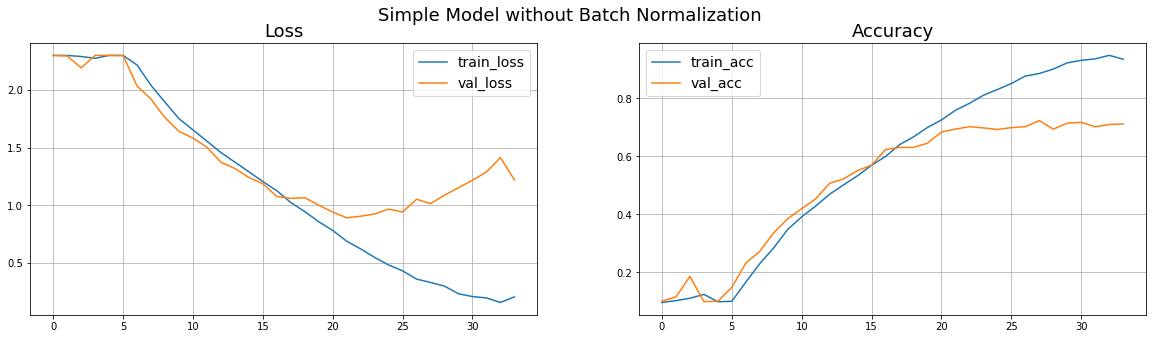

In [ ]:
plot_learning_curve(simple_model_results, title='Simple Model without Batch Normalization')

### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

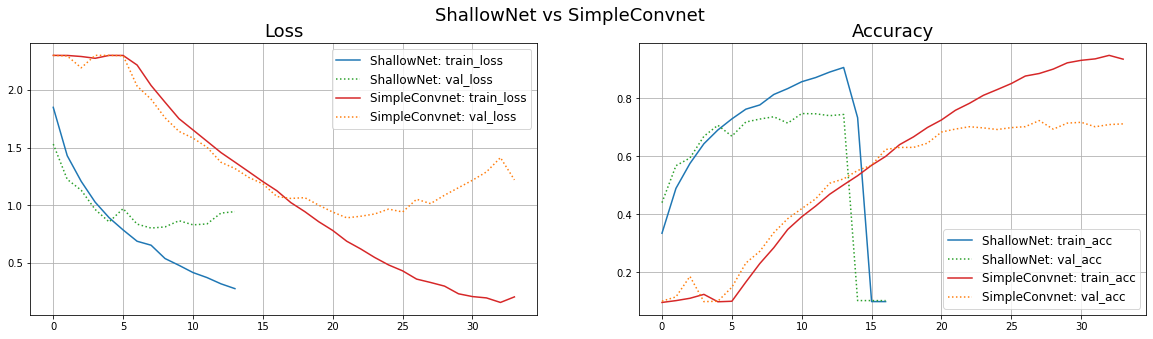

In [ ]:
compare_learning_curves(('ShallowNet',shallow_model_results), ('SimpleConvnet',simple_model_results), title='ShallowNet vs SimpleConvnet')

My observations:
*   SimpleNet has higher training loss and lower training accuracy at the beginning comparing to ShallowNet. However, SimpleNet eventually outperform ShallowNet.
*   ShallwNet stops learning after 10+ epochs, and it's accuracy dropped suddenly. This indicates that the optimization of ShallowNet diverges.
*   In contrast, SimpleNet continues to learn untill the optimization converges.
*   The reason that SimpleNet converges but ShallowNet diverges might be that the learning rate is too high for the ShallowNet, and the magnitude of ShallowNet's gradient is larger than the magnitude of SimpleNet's gradient since SimpleNet is deeper than ShallowNet.
*   The difference between train performance and validation performance becomes larger and larger as the number of epochs increase for both ShallowNet and SimpleNet. This indicats that both models suffer from overfitting.


### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [14]:
class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
        
        # TODO
        self.block0 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool_halve = nn.MaxPool2d(kernel_size=2)
        #self.pool_final = nn.MaxPool2d(kernel_size=8)
        self.linear = nn.Linear(256, num_classes, bias=True)
    
    def forward(self, x):
        
        # TODO
        x = self.block0(x)
        x = self.block1(x)
        x = self.pool_halve(x)
        x = self.block2(x)
        x = self.pool_halve(x)
        x = self.block3(x)
        #x = self.pool_final(x)
        x = torch.max(torch.max(x, dim=-1)[0], dim=-1)[0]
        output = self.linear(x.view(-1,256))
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
simple2_model = SimpleConvnet2(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(simple2_model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
simple2_model_results = train_loop(simple2_model, criterion, optimizer, train_loader, val_loader, model_name='simple2')

[EPOCH]: 0, [TRAIN LOSS]: 2.949344, [TRAIN ACCURACY]: 0.281
[EPOCH]: 0, [VAL LOSS]: 2.069551, [VAL ACCURACY]: 0.371 

[EPOCH]: 1, [TRAIN LOSS]: 1.789382, [TRAIN ACCURACY]: 0.417
[EPOCH]: 1, [VAL LOSS]: 1.569388, [VAL ACCURACY]: 0.462 

[EPOCH]: 2, [TRAIN LOSS]: 1.507661, [TRAIN ACCURACY]: 0.495
[EPOCH]: 2, [VAL LOSS]: 1.392874, [VAL ACCURACY]: 0.531 

[EPOCH]: 3, [TRAIN LOSS]: 1.311145, [TRAIN ACCURACY]: 0.553
[EPOCH]: 3, [VAL LOSS]: 1.232289, [VAL ACCURACY]: 0.590 

[EPOCH]: 4, [TRAIN LOSS]: 1.146826, [TRAIN ACCURACY]: 0.608
[EPOCH]: 4, [VAL LOSS]: 1.200479, [VAL ACCURACY]: 0.581 

[EPOCH]: 5, [TRAIN LOSS]: 1.016484, [TRAIN ACCURACY]: 0.651
[EPOCH]: 5, [VAL LOSS]: 1.078865, [VAL ACCURACY]: 0.649 

[EPOCH]: 6, [TRAIN LOSS]: 0.896902, [TRAIN ACCURACY]: 0.692
[EPOCH]: 6, [VAL LOSS]: 0.938706, [VAL ACCURACY]: 0.676 

[EPOCH]: 7, [TRAIN LOSS]: 0.798969, [TRAIN ACCURACY]: 0.727
[EPOCH]: 7, [VAL LOSS]: 0.954183, [VAL ACCURACY]: 0.679 

[EPOCH]: 8, [TRAIN LOSS]: 0.696690, [TRAIN ACCURACY]: 0.

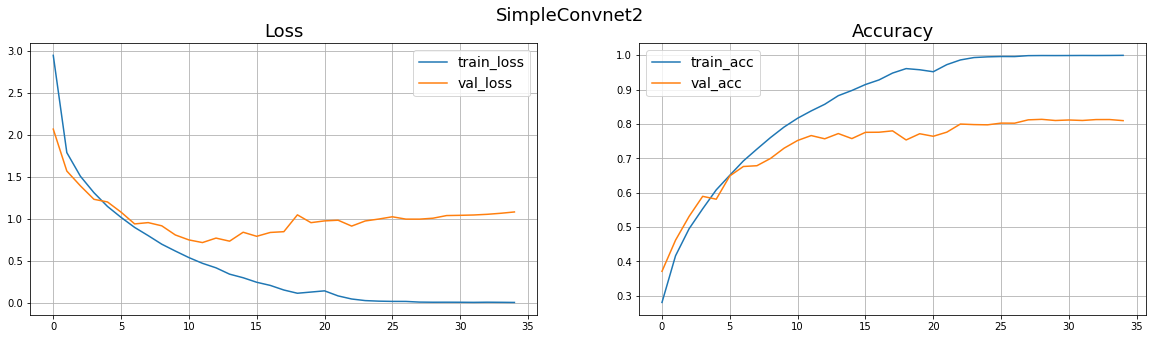

In [ ]:
plot_learning_curve(simple2_model_results, title='SimpleConvnet2')

#### Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 

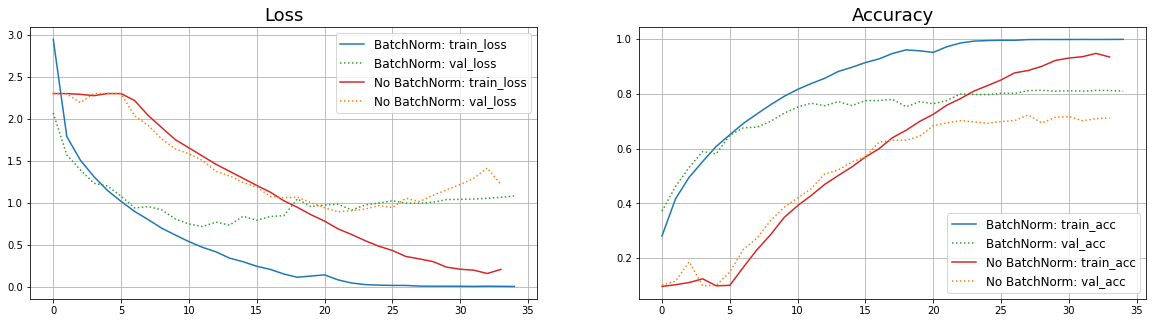

In [ ]:
compare_learning_curves(('BatchNorm', simple2_model_results),('No BatchNorm', simple_model_results))

My observations:


*   Adding batch normalization significantly improves the performance of the model. The validation accuracy increased from ~70% to ~80% after adding batch normalization. The train accuracy is increased as well.
*   The model learns faster and can learn better with batch normalization. The train loss with batch normalization is lower than the train loss without batch normalization. Also, the slope of the training curve with batch normalization is much steeper than that of the traning curve without batch normalization.
*   The model with batch normalization starts to overfit earlier than the model without batch normalization. However, the final generalization gap is roughly the same for both models.



#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [ ]:
simple_model_ADAM = SimpleConvnet(3, 10).to(device)
simple2_model_ADAM = SimpleConvnet2(3, 10).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')

optimizer1 = torch.optim.Adam(simple_model_ADAM.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(simple2_model_ADAM.parameters(), lr=1e-4)

simple_model_ADAM_results = train_loop(simple_model_ADAM, criterion, optimizer1, train_loader, val_loader, model_name='simple_ADAM')
simple2_model_ADAM_results = train_loop(simple2_model_ADAM, criterion, optimizer2, train_loader, val_loader, model_name='simple2_ADAM')

[EPOCH]: 0, [TRAIN LOSS]: 1.939955, [TRAIN ACCURACY]: 0.285
[EPOCH]: 0, [VAL LOSS]: 1.722475, [VAL ACCURACY]: 0.372 

[EPOCH]: 1, [TRAIN LOSS]: 1.600232, [TRAIN ACCURACY]: 0.420
[EPOCH]: 1, [VAL LOSS]: 1.531716, [VAL ACCURACY]: 0.449 

[EPOCH]: 2, [TRAIN LOSS]: 1.425527, [TRAIN ACCURACY]: 0.486
[EPOCH]: 2, [VAL LOSS]: 1.605712, [VAL ACCURACY]: 0.441 

[EPOCH]: 3, [TRAIN LOSS]: 1.297153, [TRAIN ACCURACY]: 0.538
[EPOCH]: 3, [VAL LOSS]: 1.358158, [VAL ACCURACY]: 0.515 

[EPOCH]: 4, [TRAIN LOSS]: 1.171112, [TRAIN ACCURACY]: 0.584
[EPOCH]: 4, [VAL LOSS]: 1.233735, [VAL ACCURACY]: 0.566 

[EPOCH]: 5, [TRAIN LOSS]: 1.056171, [TRAIN ACCURACY]: 0.628
[EPOCH]: 5, [VAL LOSS]: 1.116909, [VAL ACCURACY]: 0.608 

[EPOCH]: 6, [TRAIN LOSS]: 0.952380, [TRAIN ACCURACY]: 0.665
[EPOCH]: 6, [VAL LOSS]: 1.067741, [VAL ACCURACY]: 0.626 

[EPOCH]: 7, [TRAIN LOSS]: 0.865155, [TRAIN ACCURACY]: 0.697
[EPOCH]: 7, [VAL LOSS]: 1.190534, [VAL ACCURACY]: 0.604 

[EPOCH]: 8, [TRAIN LOSS]: 0.780735, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 1.445499, [TRAIN ACCURACY]: 0.479
[EPOCH]: 0, [VAL LOSS]: 1.187914, [VAL ACCURACY]: 0.576 

[EPOCH]: 1, [TRAIN LOSS]: 1.005801, [TRAIN ACCURACY]: 0.646
[EPOCH]: 1, [VAL LOSS]: 1.015590, [VAL ACCURACY]: 0.643 

[EPOCH]: 2, [TRAIN LOSS]: 0.772887, [TRAIN ACCURACY]: 0.737
[EPOCH]: 2, [VAL LOSS]: 0.884414, [VAL ACCURACY]: 0.692 

[EPOCH]: 3, [TRAIN LOSS]: 0.597422, [TRAIN ACCURACY]: 0.804
[EPOCH]: 3, [VAL LOSS]: 0.828464, [VAL ACCURACY]: 0.709 

[EPOCH]: 4, [TRAIN LOSS]: 0.446129, [TRAIN ACCURACY]: 0.864
[EPOCH]: 4, [VAL LOSS]: 0.794592, [VAL ACCURACY]: 0.717 

[EPOCH]: 5, [TRAIN LOSS]: 0.304540, [TRAIN ACCURACY]: 0.917
[EPOCH]: 5, [VAL LOSS]: 0.799824, [VAL ACCURACY]: 0.723 

[EPOCH]: 6, [TRAIN LOSS]: 0.184887, [TRAIN ACCURACY]: 0.960
[EPOCH]: 6, [VAL LOSS]: 0.785749, [VAL ACCURACY]: 0.739 

[EPOCH]: 7, [TRAIN LOSS]: 0.098394, [TRAIN ACCURACY]: 0.984
[EPOCH]: 7, [VAL LOSS]: 0.858794, [VAL ACCURACY]: 0.729 

[EPOCH]: 8, [TRAIN LOSS]: 0.055965, [TRAIN ACCURACY]: 0.

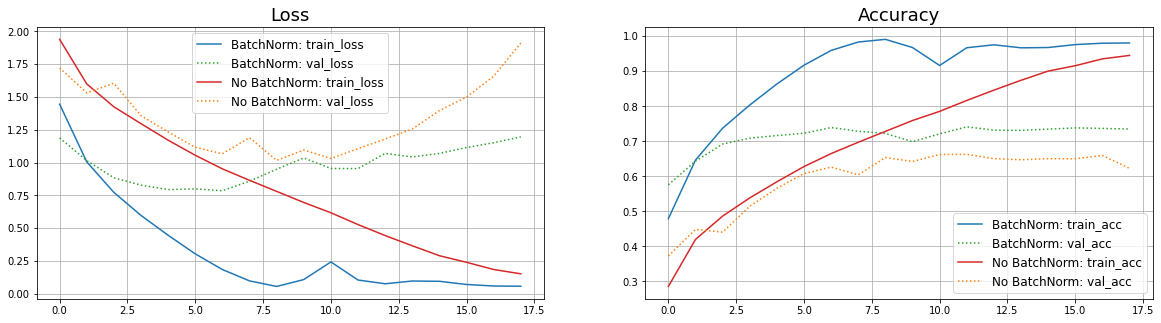

In [ ]:
compare_learning_curves(('BatchNorm', simple2_model_ADAM_results),('No BatchNorm', simple_model_ADAM_results))

My observations:

*   SimpleConvnet2 still has better performance than SimpleConvnet regarding both loss and accuracy.

*   Now with ADAM optimizer, both models learn faster than using SGD. Both the two models trained 16 epochs until they finished learning, while the two models need more than 30 epochs with SGD optimizer.

*   With ADAM, the model with batch normalization learns way way much faster than the model without batch normalization. The model with batch normalizatoin used only 8 epochs to reach the highest training accuracy. However, I'm not sure why SimpleConvnet2 continues training after epoch 8.

*   To my surprise, the validation accuracy of SimpleConvnet2 is lower when using ADAM than when using SGD. The generalization gab of both models becomes larger with ADAM.




#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 


In [16]:
# TODO : Initialize the model and cast to correct device
simple2_model_overfit = SimpleConvnet2(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.Adam(simple2_model_overfit.parameters(), lr=1e-4)

# TODO : Run the training loop using this model
batch_train = next(iter(train_loader)) # Get one batch of data
simple2_model_overfit_results = train_loop(simple2_model_overfit, criterion, optimizer, [batch_train], val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 3.671935, [TRAIN ACCURACY]: 0.125
[EPOCH]: 0, [VAL LOSS]: 2.303949, [VAL ACCURACY]: 0.101 

[EPOCH]: 1, [TRAIN LOSS]: 1.825800, [TRAIN ACCURACY]: 0.391
[EPOCH]: 1, [VAL LOSS]: 2.304203, [VAL ACCURACY]: 0.101 

[EPOCH]: 2, [TRAIN LOSS]: 0.764562, [TRAIN ACCURACY]: 0.852
[EPOCH]: 2, [VAL LOSS]: 2.304554, [VAL ACCURACY]: 0.101 

[EPOCH]: 3, [TRAIN LOSS]: 0.240922, [TRAIN ACCURACY]: 1.000
[EPOCH]: 3, [VAL LOSS]: 2.304988, [VAL ACCURACY]: 0.101 

[EPOCH]: 4, [TRAIN LOSS]: 0.100210, [TRAIN ACCURACY]: 1.000
[EPOCH]: 4, [VAL LOSS]: 2.305591, [VAL ACCURACY]: 0.101 

[EPOCH]: 5, [TRAIN LOSS]: 0.052925, [TRAIN ACCURACY]: 1.000
[EPOCH]: 5, [VAL LOSS]: 2.306440, [VAL ACCURACY]: 0.101 



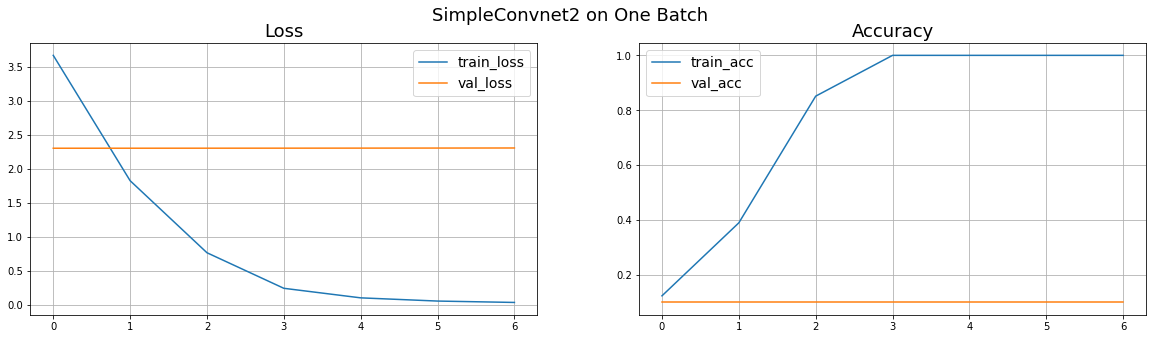

In [17]:
plot_learning_curve(simple2_model_overfit_results, title='SimpleConvnet2 on One Batch')

### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the input_channels, output_channels, kernel_size and padding parameters. 

In [15]:
class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        
        # TODO
        self.block0 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool_halve = nn.MaxPool2d(kernel_size=2)
        #self.pool_final = nn.MaxPool2d(kernel_size=8)
        self.linear = nn.Linear(256, num_classes, bias=True)

        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm2d(128)
        self.norm3 = nn.BatchNorm2d(256)
        
        self.res_conv1 = nn.Conv2d(64, 64, kernel_size=1)
        self.res_conv2 = nn.Conv2d(64, 128, kernel_size=1)
        self.res_conv3 = nn.Conv2d(128, 256, kernel_size=1)
    
    def forward(self, x):
        
        # TODO 
        x = self.block0(x)

        res = self.res_conv1(x) # transform residual
        x = self.block1(x)
        x = x + res # add residual
        x = self.norm1(x)
        x = self.pool_halve(x)

        res = self.res_conv2(x)
        x = self.block2(x)
        x = x + res
        x = self.norm2(x)
        x = self.pool_halve(x)

        res = self.res_conv3(x)
        x = self.block3(x)
        x = x + res
        x = self.norm3(x)
        #x = self.pool_final(x)
        x = torch.max(torch.max(x, dim=-1)[0], dim=-1)[0] # final max pooling
        output = self.linear(x.view(-1,256))
        
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
res_model = ResidualConvnet(3, 10).to(device)

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(res_model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
res_results = train_loop(res_model, criterion, optimizer,  train_loader, val_loader, model_name='residual')

[EPOCH]: 0, [TRAIN LOSS]: 2.392386, [TRAIN ACCURACY]: 0.333
[EPOCH]: 0, [VAL LOSS]: 1.555502, [VAL ACCURACY]: 0.450 

[EPOCH]: 1, [TRAIN LOSS]: 1.464091, [TRAIN ACCURACY]: 0.499
[EPOCH]: 1, [VAL LOSS]: 1.205469, [VAL ACCURACY]: 0.578 

[EPOCH]: 2, [TRAIN LOSS]: 1.155072, [TRAIN ACCURACY]: 0.612
[EPOCH]: 2, [VAL LOSS]: 1.069045, [VAL ACCURACY]: 0.646 

[EPOCH]: 3, [TRAIN LOSS]: 0.907885, [TRAIN ACCURACY]: 0.695
[EPOCH]: 3, [VAL LOSS]: 0.841951, [VAL ACCURACY]: 0.724 

[EPOCH]: 4, [TRAIN LOSS]: 0.733676, [TRAIN ACCURACY]: 0.756
[EPOCH]: 4, [VAL LOSS]: 0.813141, [VAL ACCURACY]: 0.746 

[EPOCH]: 5, [TRAIN LOSS]: 0.616805, [TRAIN ACCURACY]: 0.796
[EPOCH]: 5, [VAL LOSS]: 0.713401, [VAL ACCURACY]: 0.754 

[EPOCH]: 6, [TRAIN LOSS]: 0.506087, [TRAIN ACCURACY]: 0.830
[EPOCH]: 6, [VAL LOSS]: 0.599663, [VAL ACCURACY]: 0.794 

[EPOCH]: 7, [TRAIN LOSS]: 0.414493, [TRAIN ACCURACY]: 0.860
[EPOCH]: 7, [VAL LOSS]: 0.591668, [VAL ACCURACY]: 0.808 

[EPOCH]: 8, [TRAIN LOSS]: 0.334915, [TRAIN ACCURACY]: 0.

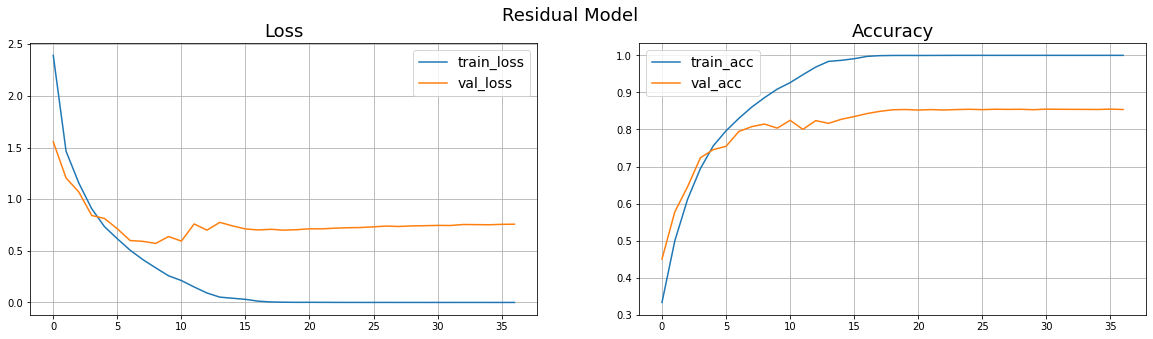

In [ ]:
plot_learning_curve(res_results, title='Residual Model')

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

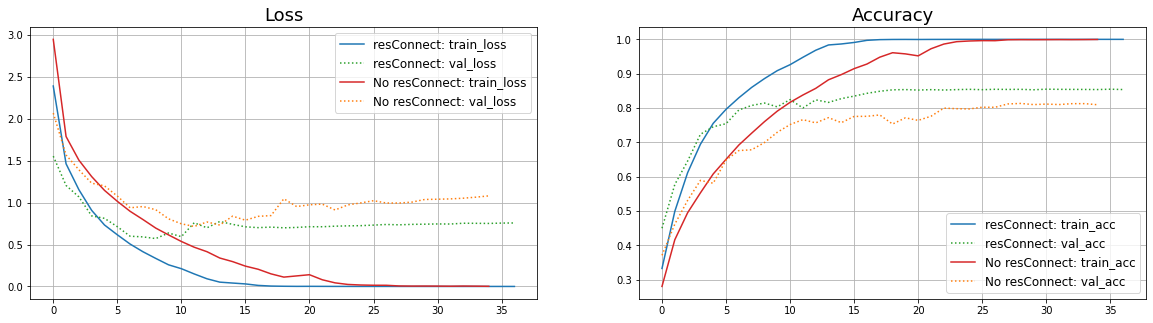

In [ ]:
compare_learning_curves(('resConnect', res_results),('No resConnect', simple2_model_results))

My observations:

*   ResConvnet has lower training low and higher traning accuracy than SimpleConvnet2.

*   ResConvnet has a smaller generalization gap tha SimpleConvnet2.

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding random transformations to the input data to make your model more robust and prevent it from memorizing the input data. 

Torchvision provides several transforms that you can readily apply to your data. Experiment with adding a few transforms and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and try to achieve better perfomance on the validation set. 

In [16]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])
'''
RandomApply, RandomChoice, RandomOrder

Candidate transforms
    ColorJitter:        Randomly change the brightness, contrast and saturation of an image.
    RandomAffine:       Random affine transformation of the image keeping center invariant.
    RandomCrop:         Crop the given PIL Image at a random location.
    RandomGrayscale:    Randomly convert image to grayscale with a probability of p (default 0.1)
    RandomHorizontalFlip: Horizontally flip the given image randomly with a given probability.
    RandomPerspective:  Performs Perspective transformation of the given PIL Image randomly with a given probability.
    RandomRotation:     Rotate the image by angle.
    RandomVerticalFlip: Vertically flip the given PIL Image randomly with a given probability.
    RandomErasing:      Randomly selects a rectangle region in an image and erases its pixels.
'''

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here 
                                      transforms.RandomApply([transforms.ColorJitter(0.5,0.5,0.5,0.5)], p=0.2),
                                      transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.25,0.25), scale=(1,1.5), shear=20)], p=0.2),
                                      transforms.RandomApply([transforms.RandomPerspective()], p=0.2),
                                      transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
                                      transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])

In [17]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [18]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)

#### Use the residual network that you built above and use data augmentation to reduce the overfitting 

##### Experiment 1: P(Transform)=0.41, P(ColorJitter) = P(Affine) = P(Perspective) = P(VerticalFlip) = P(HorizontalFlip) = 0.1

In [35]:
# TODO : Initialize the model and cast to correct device
res_model_reduce_overfit = ResidualConvnet(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(res_model_reduce_overfit.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
residual_reduce_overfit_results = train_loop(res_model_reduce_overfit, criterion, optimizer,  train_loader, val_loader, model_name='residual_reduce_overfit')

[EPOCH]: 0, [TRAIN LOSS]: 2.623747, [TRAIN ACCURACY]: 0.281
[EPOCH]: 0, [VAL LOSS]: 1.694372, [VAL ACCURACY]: 0.424 

[EPOCH]: 1, [TRAIN LOSS]: 1.742539, [TRAIN ACCURACY]: 0.418
[EPOCH]: 1, [VAL LOSS]: 1.358176, [VAL ACCURACY]: 0.535 

[EPOCH]: 2, [TRAIN LOSS]: 1.496122, [TRAIN ACCURACY]: 0.497
[EPOCH]: 2, [VAL LOSS]: 1.168222, [VAL ACCURACY]: 0.597 

[EPOCH]: 3, [TRAIN LOSS]: 1.290574, [TRAIN ACCURACY]: 0.561
[EPOCH]: 3, [VAL LOSS]: 0.970055, [VAL ACCURACY]: 0.659 

[EPOCH]: 4, [TRAIN LOSS]: 1.132999, [TRAIN ACCURACY]: 0.618
[EPOCH]: 4, [VAL LOSS]: 0.990263, [VAL ACCURACY]: 0.647 

[EPOCH]: 5, [TRAIN LOSS]: 1.004979, [TRAIN ACCURACY]: 0.660
[EPOCH]: 5, [VAL LOSS]: 0.916005, [VAL ACCURACY]: 0.691 

[EPOCH]: 6, [TRAIN LOSS]: 0.881436, [TRAIN ACCURACY]: 0.699
[EPOCH]: 6, [VAL LOSS]: 0.766732, [VAL ACCURACY]: 0.741 

[EPOCH]: 7, [TRAIN LOSS]: 0.787972, [TRAIN ACCURACY]: 0.732
[EPOCH]: 7, [VAL LOSS]: 0.712555, [VAL ACCURACY]: 0.761 

[EPOCH]: 8, [TRAIN LOSS]: 0.720082, [TRAIN ACCURACY]: 0.

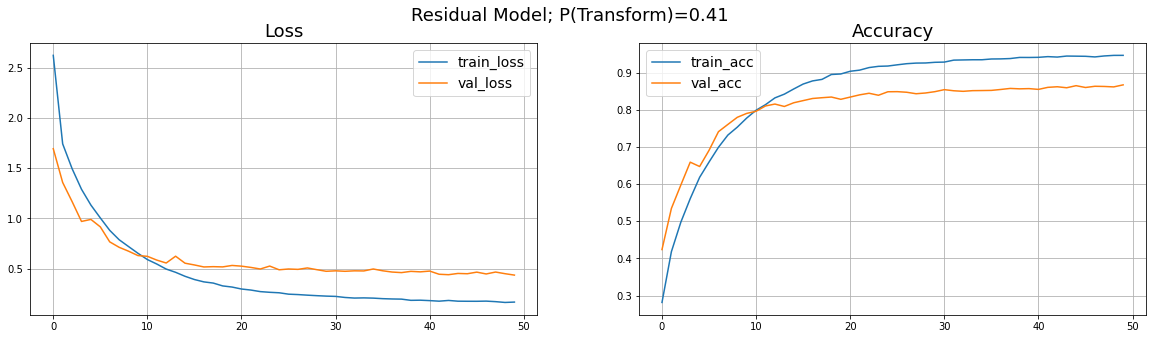

In [57]:
plot_learning_curve(residual_reduce_overfit_results, title='Residual Model; P(Transform)=0.41')

##### Experiment 2: P(Transform)=0.67, P(ColorJitter) = P(Affine) = P(Perspective) = P(VerticalFlip) = P(HorizontalFlip) = 0.2

In [58]:
# TODO : Initialize the model and cast to correct device
res_model_reduce_overfit = ResidualConvnet(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(res_model_reduce_overfit.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
residual_reduce_overfit_results = train_loop(res_model_reduce_overfit, criterion, optimizer,  train_loader, val_loader, model_name='residual_reduce_overfit_2')

[EPOCH]: 0, [TRAIN LOSS]: 2.529538, [TRAIN ACCURACY]: 0.269
[EPOCH]: 0, [VAL LOSS]: 2.125602, [VAL ACCURACY]: 0.410 

[EPOCH]: 1, [TRAIN LOSS]: 1.790731, [TRAIN ACCURACY]: 0.390
[EPOCH]: 1, [VAL LOSS]: 1.376236, [VAL ACCURACY]: 0.518 

[EPOCH]: 2, [TRAIN LOSS]: 1.547466, [TRAIN ACCURACY]: 0.464
[EPOCH]: 2, [VAL LOSS]: 1.299339, [VAL ACCURACY]: 0.537 

[EPOCH]: 3, [TRAIN LOSS]: 1.376879, [TRAIN ACCURACY]: 0.526
[EPOCH]: 3, [VAL LOSS]: 1.057613, [VAL ACCURACY]: 0.635 

[EPOCH]: 4, [TRAIN LOSS]: 1.232567, [TRAIN ACCURACY]: 0.577
[EPOCH]: 4, [VAL LOSS]: 1.094434, [VAL ACCURACY]: 0.663 

[EPOCH]: 5, [TRAIN LOSS]: 1.108896, [TRAIN ACCURACY]: 0.621
[EPOCH]: 5, [VAL LOSS]: 0.883889, [VAL ACCURACY]: 0.710 

[EPOCH]: 6, [TRAIN LOSS]: 1.001210, [TRAIN ACCURACY]: 0.655
[EPOCH]: 6, [VAL LOSS]: 0.947337, [VAL ACCURACY]: 0.708 

[EPOCH]: 7, [TRAIN LOSS]: 0.925113, [TRAIN ACCURACY]: 0.679
[EPOCH]: 7, [VAL LOSS]: 0.680281, [VAL ACCURACY]: 0.768 

[EPOCH]: 8, [TRAIN LOSS]: 0.854991, [TRAIN ACCURACY]: 0.

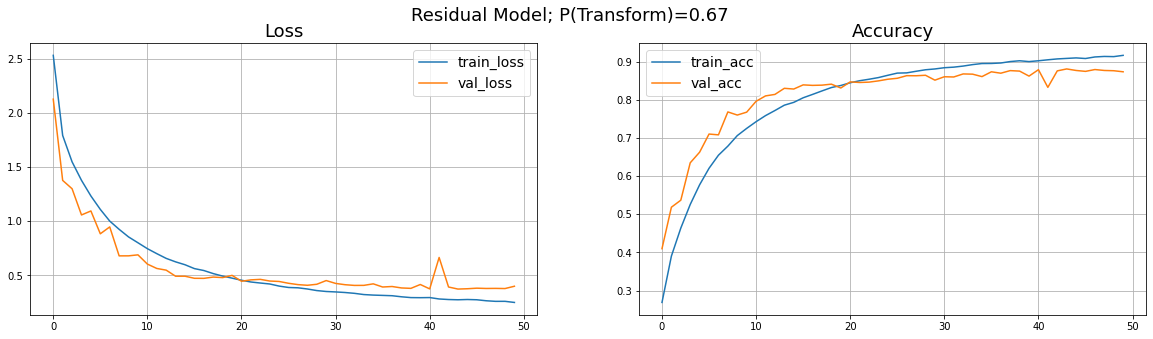

In [59]:
plot_learning_curve(residual_reduce_overfit_results, title='Residual Model; P(Transform)=0.67')

### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [19]:
from torch.optim.lr_scheduler import StepLR

In [20]:
def train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader, model_name='temp'):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    scheduler : Instance of scheduler class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):

        # TODO : Set the model to train mode    
        model.train()    

        # TODO: Loop over the training set 
        n_loss = 0.0
        n_correct = 0
        n_samples = 0
        for i, (inputs, targets) in enumerate(train_loader):

            # TODO: Put the inputs and targets on the write device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # TODO: Feed forward to get the logits
            logits = model(inputs)

            # TODO: Compute the loss and accuracy
            loss = criterion(logits, targets)
            predictions = torch.max(logits, dim=1)[1]
            correct = (predictions == targets).sum().item()

            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()

            # TODO: Update params
            optimizer.step()
            
            # TODO: Keep track of accuracy and loss
            n_loss += loss.item()
            n_correct += correct
            n_samples += targets.size()[0]
        train_losses.append(n_loss/n_samples)
        train_accuracies.append(n_correct/n_samples)

        
        # Switch the model to eval mode
        # TODO
        model.eval()


        with torch.no_grad():
            # TODO: Loop over the validation set 
            n_loss = 0.0
            n_correct = 0
            n_samples = 0
            for i, (inputs, targets) in enumerate(val_loader):
            
                # TODO: Put the inputs and targets on the write device
                inputs = inputs.to(device)
                targets = targets.to(device)
            
                # TODO: Feed forward to get the logits
                logits = model(inputs)

                # TODO: Compute the loss and accuracy
                loss = criterion(logits, targets)
                predictions = torch.max(logits, dim=1)[1]
                correct = (predictions == targets).sum().item()

                # TODO: Keep track of accuracy and loss
                n_loss += loss.item()
                n_correct += correct
                n_samples += targets.size()[0]
            val_losses.append(n_loss/n_samples)
            val_accuracies.append(n_correct/n_samples)

        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          my_drive_path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2'
          torch.save(
              {
               'accuracy': best_val,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'epoch_number': t,
              },
              f'{my_drive_path}/results/Q2/{model_name}.pt'
          )
          
        else:
          patience_counter += 1    
          
          if patience_counter > max_patience: 
            break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

        # TODO : scheduler step
        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

In [63]:
# TODO : Initialize the model and cast to correct device
res_model_StepLR = ResidualConvnet(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(res_model_StepLR.parameters(), lr=1e-3)

# TODO : Initialize the scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# TODO : Run the training loop using this model
res_StepLR_results = train_loop2(res_model_StepLR, criterion, optimizer, scheduler, train_loader, val_loader, model_name='res_StepLR_stepSize3_gamma0.5')

[EPOCH]: 0, [TRAIN LOSS]: 2.478013, [TRAIN ACCURACY]: 0.257
[EPOCH]: 0, [VAL LOSS]: 1.648231, [VAL ACCURACY]: 0.382 

[EPOCH]: 1, [TRAIN LOSS]: 1.750779, [TRAIN ACCURACY]: 0.378
[EPOCH]: 1, [VAL LOSS]: 1.396302, [VAL ACCURACY]: 0.493 

[EPOCH]: 2, [TRAIN LOSS]: 1.556088, [TRAIN ACCURACY]: 0.441
[EPOCH]: 2, [VAL LOSS]: 1.192494, [VAL ACCURACY]: 0.574 

[EPOCH]: 3, [TRAIN LOSS]: 1.266071, [TRAIN ACCURACY]: 0.548
[EPOCH]: 3, [VAL LOSS]: 0.995572, [VAL ACCURACY]: 0.652 

[EPOCH]: 4, [TRAIN LOSS]: 1.173897, [TRAIN ACCURACY]: 0.585
[EPOCH]: 4, [VAL LOSS]: 0.910807, [VAL ACCURACY]: 0.677 

[EPOCH]: 5, [TRAIN LOSS]: 1.082327, [TRAIN ACCURACY]: 0.616
[EPOCH]: 5, [VAL LOSS]: 0.932416, [VAL ACCURACY]: 0.672 

[EPOCH]: 6, [TRAIN LOSS]: 0.940965, [TRAIN ACCURACY]: 0.668
[EPOCH]: 6, [VAL LOSS]: 0.764348, [VAL ACCURACY]: 0.733 

[EPOCH]: 7, [TRAIN LOSS]: 0.889143, [TRAIN ACCURACY]: 0.688
[EPOCH]: 7, [VAL LOSS]: 0.713542, [VAL ACCURACY]: 0.747 

[EPOCH]: 8, [TRAIN LOSS]: 0.860021, [TRAIN ACCURACY]: 0.

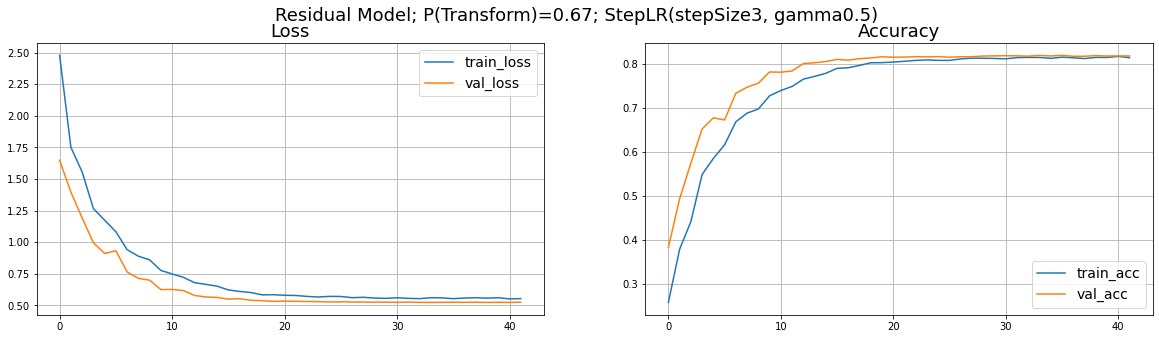

In [64]:
plot_learning_curve(res_StepLR_results, title='Residual Model; P(Transform)=0.67; StepLR(stepSize3, gamma0.5)')

### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





In [21]:
import json

path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2/results/Q2.11/'

def plot_learning_curves(results_dict, title=None):
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
    for i, key in enumerate(results_dict):
        train_losses, train_accuracies, val_losses, val_accuracies = results_dict[key]
        ax.plot(train_losses, label=f'{key} train', c=colors[i])
        ax.plot(val_losses, label=f'{key} val', c=colors[i], ls=':')
        ax.legend(fontsize=12)
        ax.set_xlabel('epochs',fontsize=12)
        ax.set_ylabel('loss',fontsize=12)
        ax.grid()
    if title:
        fig.suptitle(title,fontsize=15)
    plt.show()

In [78]:
# SGD lr
SGD_lr_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
SGD_lr_results = {}

for lr in SGD_lr_list:
    model = ResidualConvnet(3, 10).to(device)
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) # SGD
    results = train_loop(model, criterion, optimizer, train_loader, val_loader, model_name=f'res_SGDlr_{lr}')
    SGD_lr_results[lr] = results

with open(path+'SGD_lr_results.json', 'w') as fp:
    json.dump(SGD_lr_results, fp)

[EPOCH]: 0, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 0, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 1, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 1, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 2, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 2, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 3, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 3, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 4, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 4, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 5, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 5, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 



[EPOCH]: 0, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.100
[EPOCH]: 0, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 1, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 1, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 2, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 2, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 3, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 3, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 4, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 4, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 

[EPOCH]: 5, [TRAIN LOSS]: nan, [TRAIN ACCURACY]: 0.099
[EPOCH]: 5, [VAL LOSS]: nan, [VAL ACCURACY]: 0.103 



[EPOCH]: 0, [TRAIN LOSS]: 2.661860, [TRAIN ACCURACY]: 0.248
[EPOCH]: 0, [VAL LOSS]: 1.761795, [VAL ACCURACY]: 0.385 

[EPOCH]: 1, [TRAIN LOSS]: 1.834436, [TRAIN ACCURACY]: 0.374
[EPOCH]: 1, [VAL LOSS]: 1.346431, [VAL ACCURACY]: 0.519 

[EPOCH]: 2, [TRAIN LOSS]: 1.569130, [TRAIN ACCURACY]: 0.457
[EPOCH]: 2, [VAL LOSS]: 1.293019, [VAL ACCURACY]: 0.566 

[EPOCH]: 3, [TRAIN LOSS]: 1.356160, [TRAIN ACCURACY]: 0.532
[EPOCH]: 3, [VAL LOSS]: 1.120494, [VAL ACCURACY]: 0.628 

[EPOCH]: 4, [TRAIN LOSS]: 1.210443, [TRAIN ACCURACY]: 0.580
[EPOCH]: 4, [VAL LOSS]: 0.892832, [VAL ACCURACY]: 0.684 

[EPOCH]: 5, [TRAIN LOSS]: 1.094674, [TRAIN ACCURACY]: 0.623
[EPOCH]: 5, [VAL LOSS]: 0.823296, [VAL ACCURACY]: 0.718 

[EPOCH]: 6, [TRAIN LOSS]: 0.994561, [TRAIN ACCURACY]: 0.656
[EPOCH]: 6, [VAL LOSS]: 0.990228, [VAL ACCURACY]: 0.692 

[EPOCH]: 7, [TRAIN LOSS]: 0.919351, [TRAIN ACCURACY]: 0.683
[EPOCH]: 7, [VAL LOSS]: 0.753950, [VAL ACCURACY]: 0.748 

[EPOCH]: 8, [TRAIN LOSS]: 0.852739, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 1.771763, [TRAIN ACCURACY]: 0.360
[EPOCH]: 0, [VAL LOSS]: 1.305008, [VAL ACCURACY]: 0.533 

[EPOCH]: 1, [TRAIN LOSS]: 1.411833, [TRAIN ACCURACY]: 0.490
[EPOCH]: 1, [VAL LOSS]: 1.098391, [VAL ACCURACY]: 0.603 

[EPOCH]: 2, [TRAIN LOSS]: 1.229739, [TRAIN ACCURACY]: 0.562
[EPOCH]: 2, [VAL LOSS]: 0.998105, [VAL ACCURACY]: 0.635 

[EPOCH]: 3, [TRAIN LOSS]: 1.108025, [TRAIN ACCURACY]: 0.611
[EPOCH]: 3, [VAL LOSS]: 0.862631, [VAL ACCURACY]: 0.693 

[EPOCH]: 4, [TRAIN LOSS]: 1.007070, [TRAIN ACCURACY]: 0.641
[EPOCH]: 4, [VAL LOSS]: 0.753260, [VAL ACCURACY]: 0.735 

[EPOCH]: 5, [TRAIN LOSS]: 0.926975, [TRAIN ACCURACY]: 0.675
[EPOCH]: 5, [VAL LOSS]: 0.722560, [VAL ACCURACY]: 0.745 

[EPOCH]: 6, [TRAIN LOSS]: 0.864677, [TRAIN ACCURACY]: 0.698
[EPOCH]: 6, [VAL LOSS]: 0.670690, [VAL ACCURACY]: 0.765 

[EPOCH]: 7, [TRAIN LOSS]: 0.812170, [TRAIN ACCURACY]: 0.715
[EPOCH]: 7, [VAL LOSS]: 0.643708, [VAL ACCURACY]: 0.781 

[EPOCH]: 8, [TRAIN LOSS]: 0.764777, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.017890, [TRAIN ACCURACY]: 0.268
[EPOCH]: 0, [VAL LOSS]: 1.712889, [VAL ACCURACY]: 0.394 

[EPOCH]: 1, [TRAIN LOSS]: 1.778037, [TRAIN ACCURACY]: 0.360
[EPOCH]: 1, [VAL LOSS]: 1.542201, [VAL ACCURACY]: 0.450 

[EPOCH]: 2, [TRAIN LOSS]: 1.654211, [TRAIN ACCURACY]: 0.410
[EPOCH]: 2, [VAL LOSS]: 1.447631, [VAL ACCURACY]: 0.479 

[EPOCH]: 3, [TRAIN LOSS]: 1.569682, [TRAIN ACCURACY]: 0.437
[EPOCH]: 3, [VAL LOSS]: 1.360745, [VAL ACCURACY]: 0.526 

[EPOCH]: 4, [TRAIN LOSS]: 1.502227, [TRAIN ACCURACY]: 0.463
[EPOCH]: 4, [VAL LOSS]: 1.298986, [VAL ACCURACY]: 0.545 

[EPOCH]: 5, [TRAIN LOSS]: 1.445071, [TRAIN ACCURACY]: 0.488
[EPOCH]: 5, [VAL LOSS]: 1.251076, [VAL ACCURACY]: 0.560 

[EPOCH]: 6, [TRAIN LOSS]: 1.395690, [TRAIN ACCURACY]: 0.503
[EPOCH]: 6, [VAL LOSS]: 1.211710, [VAL ACCURACY]: 0.576 

[EPOCH]: 7, [TRAIN LOSS]: 1.354757, [TRAIN ACCURACY]: 0.520
[EPOCH]: 7, [VAL LOSS]: 1.173863, [VAL ACCURACY]: 0.587 

[EPOCH]: 8, [TRAIN LOSS]: 1.324134, [TRAIN ACCURACY]: 0.

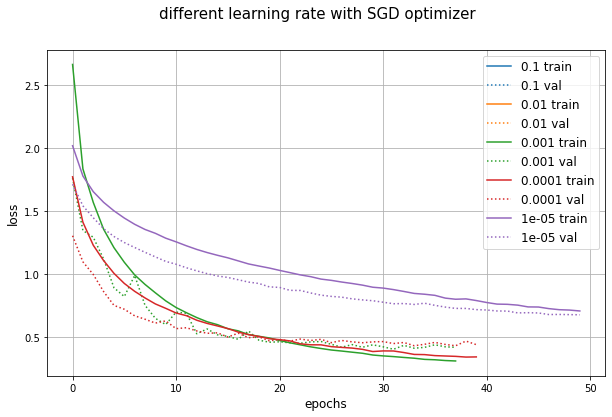

In [81]:
plot_learning_curves(SGD_lr_results, title='different learning rate with SGD optimizer')

In [79]:
# ADAM lr
ADAM_lr_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
ADAM_lr_results = {}

for lr in ADAM_lr_list:
    model = ResidualConvnet(3, 10).to(device)
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # ADAM
    results = train_loop(model, criterion, optimizer, train_loader, val_loader, model_name=f'res_ADAMlr_{lr}')
    ADAM_lr_results[lr] = results

with open(path+'ADAM_lr_results.json', 'w') as fp:
    json.dump(ADAM_lr_results, fp)

[EPOCH]: 0, [TRAIN LOSS]: 2.011053, [TRAIN ACCURACY]: 0.282
[EPOCH]: 0, [VAL LOSS]: 1.637024, [VAL ACCURACY]: 0.386 

[EPOCH]: 1, [TRAIN LOSS]: 1.630241, [TRAIN ACCURACY]: 0.406
[EPOCH]: 1, [VAL LOSS]: 1.443596, [VAL ACCURACY]: 0.487 

[EPOCH]: 2, [TRAIN LOSS]: 1.400050, [TRAIN ACCURACY]: 0.500
[EPOCH]: 2, [VAL LOSS]: 1.123212, [VAL ACCURACY]: 0.598 

[EPOCH]: 3, [TRAIN LOSS]: 1.186333, [TRAIN ACCURACY]: 0.576
[EPOCH]: 3, [VAL LOSS]: 0.958995, [VAL ACCURACY]: 0.658 

[EPOCH]: 4, [TRAIN LOSS]: 1.051116, [TRAIN ACCURACY]: 0.632
[EPOCH]: 4, [VAL LOSS]: 0.829336, [VAL ACCURACY]: 0.709 

[EPOCH]: 5, [TRAIN LOSS]: 0.927892, [TRAIN ACCURACY]: 0.675
[EPOCH]: 5, [VAL LOSS]: 0.717576, [VAL ACCURACY]: 0.753 

[EPOCH]: 6, [TRAIN LOSS]: 0.840419, [TRAIN ACCURACY]: 0.706
[EPOCH]: 6, [VAL LOSS]: 0.651419, [VAL ACCURACY]: 0.774 

[EPOCH]: 7, [TRAIN LOSS]: 0.776092, [TRAIN ACCURACY]: 0.729
[EPOCH]: 7, [VAL LOSS]: 0.596176, [VAL ACCURACY]: 0.796 

[EPOCH]: 8, [TRAIN LOSS]: 0.721364, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 1.575071, [TRAIN ACCURACY]: 0.435
[EPOCH]: 0, [VAL LOSS]: 1.160629, [VAL ACCURACY]: 0.586 

[EPOCH]: 1, [TRAIN LOSS]: 1.100886, [TRAIN ACCURACY]: 0.610
[EPOCH]: 1, [VAL LOSS]: 0.867338, [VAL ACCURACY]: 0.696 

[EPOCH]: 2, [TRAIN LOSS]: 0.914407, [TRAIN ACCURACY]: 0.679
[EPOCH]: 2, [VAL LOSS]: 0.645434, [VAL ACCURACY]: 0.777 

[EPOCH]: 3, [TRAIN LOSS]: 0.793122, [TRAIN ACCURACY]: 0.722
[EPOCH]: 3, [VAL LOSS]: 0.591791, [VAL ACCURACY]: 0.796 

[EPOCH]: 4, [TRAIN LOSS]: 0.716517, [TRAIN ACCURACY]: 0.751
[EPOCH]: 4, [VAL LOSS]: 0.513017, [VAL ACCURACY]: 0.824 

[EPOCH]: 5, [TRAIN LOSS]: 0.661465, [TRAIN ACCURACY]: 0.772
[EPOCH]: 5, [VAL LOSS]: 0.512910, [VAL ACCURACY]: 0.827 

[EPOCH]: 6, [TRAIN LOSS]: 0.612625, [TRAIN ACCURACY]: 0.789
[EPOCH]: 6, [VAL LOSS]: 0.477230, [VAL ACCURACY]: 0.836 

[EPOCH]: 7, [TRAIN LOSS]: 0.567300, [TRAIN ACCURACY]: 0.804
[EPOCH]: 7, [VAL LOSS]: 0.492356, [VAL ACCURACY]: 0.833 

[EPOCH]: 8, [TRAIN LOSS]: 0.525757, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 1.674780, [TRAIN ACCURACY]: 0.397
[EPOCH]: 0, [VAL LOSS]: 1.220141, [VAL ACCURACY]: 0.569 

[EPOCH]: 1, [TRAIN LOSS]: 1.312896, [TRAIN ACCURACY]: 0.533
[EPOCH]: 1, [VAL LOSS]: 0.977671, [VAL ACCURACY]: 0.660 

[EPOCH]: 2, [TRAIN LOSS]: 1.118834, [TRAIN ACCURACY]: 0.608
[EPOCH]: 2, [VAL LOSS]: 0.852838, [VAL ACCURACY]: 0.706 

[EPOCH]: 3, [TRAIN LOSS]: 0.997860, [TRAIN ACCURACY]: 0.654
[EPOCH]: 3, [VAL LOSS]: 0.755828, [VAL ACCURACY]: 0.739 

[EPOCH]: 4, [TRAIN LOSS]: 0.905668, [TRAIN ACCURACY]: 0.688
[EPOCH]: 4, [VAL LOSS]: 0.717822, [VAL ACCURACY]: 0.746 

[EPOCH]: 5, [TRAIN LOSS]: 0.836431, [TRAIN ACCURACY]: 0.713
[EPOCH]: 5, [VAL LOSS]: 0.650102, [VAL ACCURACY]: 0.777 

[EPOCH]: 6, [TRAIN LOSS]: 0.772304, [TRAIN ACCURACY]: 0.736
[EPOCH]: 6, [VAL LOSS]: 0.635249, [VAL ACCURACY]: 0.780 

[EPOCH]: 7, [TRAIN LOSS]: 0.730702, [TRAIN ACCURACY]: 0.749
[EPOCH]: 7, [VAL LOSS]: 0.580515, [VAL ACCURACY]: 0.800 

[EPOCH]: 8, [TRAIN LOSS]: 0.690065, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.143254, [TRAIN ACCURACY]: 0.233
[EPOCH]: 0, [VAL LOSS]: 1.740482, [VAL ACCURACY]: 0.389 

[EPOCH]: 1, [TRAIN LOSS]: 1.791771, [TRAIN ACCURACY]: 0.365
[EPOCH]: 1, [VAL LOSS]: 1.539512, [VAL ACCURACY]: 0.467 

[EPOCH]: 2, [TRAIN LOSS]: 1.654058, [TRAIN ACCURACY]: 0.411
[EPOCH]: 2, [VAL LOSS]: 1.421802, [VAL ACCURACY]: 0.506 

[EPOCH]: 3, [TRAIN LOSS]: 1.559412, [TRAIN ACCURACY]: 0.448
[EPOCH]: 3, [VAL LOSS]: 1.340063, [VAL ACCURACY]: 0.537 

[EPOCH]: 4, [TRAIN LOSS]: 1.484941, [TRAIN ACCURACY]: 0.479
[EPOCH]: 4, [VAL LOSS]: 1.277967, [VAL ACCURACY]: 0.554 

[EPOCH]: 5, [TRAIN LOSS]: 1.429062, [TRAIN ACCURACY]: 0.495
[EPOCH]: 5, [VAL LOSS]: 1.234647, [VAL ACCURACY]: 0.572 

[EPOCH]: 6, [TRAIN LOSS]: 1.375397, [TRAIN ACCURACY]: 0.518
[EPOCH]: 6, [VAL LOSS]: 1.179740, [VAL ACCURACY]: 0.589 

[EPOCH]: 7, [TRAIN LOSS]: 1.338073, [TRAIN ACCURACY]: 0.529
[EPOCH]: 7, [VAL LOSS]: 1.153739, [VAL ACCURACY]: 0.599 

[EPOCH]: 8, [TRAIN LOSS]: 1.294708, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.910524, [TRAIN ACCURACY]: 0.107
[EPOCH]: 0, [VAL LOSS]: 2.568219, [VAL ACCURACY]: 0.126 

[EPOCH]: 1, [TRAIN LOSS]: 2.496023, [TRAIN ACCURACY]: 0.146
[EPOCH]: 1, [VAL LOSS]: 2.263619, [VAL ACCURACY]: 0.195 

[EPOCH]: 2, [TRAIN LOSS]: 2.279938, [TRAIN ACCURACY]: 0.192
[EPOCH]: 2, [VAL LOSS]: 2.098654, [VAL ACCURACY]: 0.246 

[EPOCH]: 3, [TRAIN LOSS]: 2.154176, [TRAIN ACCURACY]: 0.221
[EPOCH]: 3, [VAL LOSS]: 1.997230, [VAL ACCURACY]: 0.286 

[EPOCH]: 4, [TRAIN LOSS]: 2.077933, [TRAIN ACCURACY]: 0.255
[EPOCH]: 4, [VAL LOSS]: 1.925609, [VAL ACCURACY]: 0.319 

[EPOCH]: 5, [TRAIN LOSS]: 2.015005, [TRAIN ACCURACY]: 0.280
[EPOCH]: 5, [VAL LOSS]: 1.873271, [VAL ACCURACY]: 0.344 

[EPOCH]: 6, [TRAIN LOSS]: 1.973786, [TRAIN ACCURACY]: 0.296
[EPOCH]: 6, [VAL LOSS]: 1.826959, [VAL ACCURACY]: 0.360 

[EPOCH]: 7, [TRAIN LOSS]: 1.934739, [TRAIN ACCURACY]: 0.314
[EPOCH]: 7, [VAL LOSS]: 1.789993, [VAL ACCURACY]: 0.376 

[EPOCH]: 8, [TRAIN LOSS]: 1.910493, [TRAIN ACCURACY]: 0.

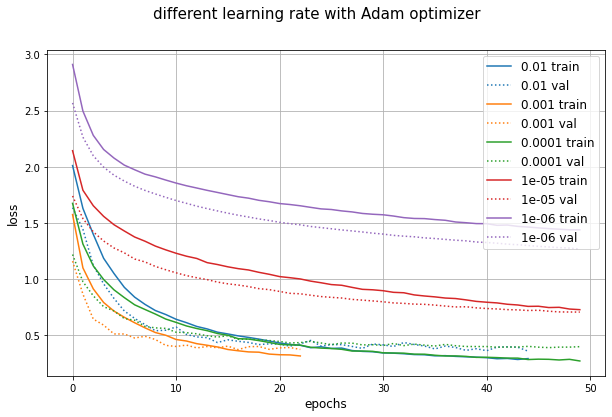

In [82]:
plot_learning_curves(ADAM_lr_results, title='different learning rate with Adam optimizer')

In [83]:
# StepLR + SGD
optimal_SGDlr = 1e-3
StepLR_gamma_list = [0.1, 0.25, 0.5, 0.75, 0.9]
StepLR_gamma_SGD_results = {}

for gamma in StepLR_gamma_list:
    model = ResidualConvnet(3, 10).to(device)
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=optimal_SGDlr) # SGD
    scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
    results = train_loop2(model, criterion, optimizer, scheduler, train_loader, val_loader, model_name=f'res_SGD_StepLR_gamma_{gamma}')
    StepLR_gamma_SGD_results[gamma] = results

with open(path+'StepLR_gamma_SGD_results.json', 'w') as fp:
    json.dump(StepLR_gamma_SGD_results, fp)

[EPOCH]: 0, [TRAIN LOSS]: 2.650846, [TRAIN ACCURACY]: 0.263
[EPOCH]: 0, [VAL LOSS]: 1.648929, [VAL ACCURACY]: 0.403 

[EPOCH]: 1, [TRAIN LOSS]: 1.828531, [TRAIN ACCURACY]: 0.379
[EPOCH]: 1, [VAL LOSS]: 1.537052, [VAL ACCURACY]: 0.470 

[EPOCH]: 2, [TRAIN LOSS]: 1.617430, [TRAIN ACCURACY]: 0.448
[EPOCH]: 2, [VAL LOSS]: 1.321446, [VAL ACCURACY]: 0.545 

[EPOCH]: 3, [TRAIN LOSS]: 1.256498, [TRAIN ACCURACY]: 0.553
[EPOCH]: 3, [VAL LOSS]: 1.045821, [VAL ACCURACY]: 0.630 

[EPOCH]: 4, [TRAIN LOSS]: 1.194529, [TRAIN ACCURACY]: 0.575
[EPOCH]: 4, [VAL LOSS]: 0.994967, [VAL ACCURACY]: 0.644 

[EPOCH]: 5, [TRAIN LOSS]: 1.160543, [TRAIN ACCURACY]: 0.585
[EPOCH]: 5, [VAL LOSS]: 0.953946, [VAL ACCURACY]: 0.663 

[EPOCH]: 6, [TRAIN LOSS]: 1.121169, [TRAIN ACCURACY]: 0.603
[EPOCH]: 6, [VAL LOSS]: 0.930403, [VAL ACCURACY]: 0.668 

[EPOCH]: 7, [TRAIN LOSS]: 1.099977, [TRAIN ACCURACY]: 0.608
[EPOCH]: 7, [VAL LOSS]: 0.923747, [VAL ACCURACY]: 0.671 

[EPOCH]: 8, [TRAIN LOSS]: 1.099800, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.720107, [TRAIN ACCURACY]: 0.250
[EPOCH]: 0, [VAL LOSS]: 1.728946, [VAL ACCURACY]: 0.397 

[EPOCH]: 1, [TRAIN LOSS]: 1.829531, [TRAIN ACCURACY]: 0.359
[EPOCH]: 1, [VAL LOSS]: 1.412451, [VAL ACCURACY]: 0.487 

[EPOCH]: 2, [TRAIN LOSS]: 1.631360, [TRAIN ACCURACY]: 0.430
[EPOCH]: 2, [VAL LOSS]: 1.305103, [VAL ACCURACY]: 0.532 

[EPOCH]: 3, [TRAIN LOSS]: 1.318647, [TRAIN ACCURACY]: 0.533
[EPOCH]: 3, [VAL LOSS]: 1.068479, [VAL ACCURACY]: 0.624 

[EPOCH]: 4, [TRAIN LOSS]: 1.251444, [TRAIN ACCURACY]: 0.556
[EPOCH]: 4, [VAL LOSS]: 1.018748, [VAL ACCURACY]: 0.639 

[EPOCH]: 5, [TRAIN LOSS]: 1.193637, [TRAIN ACCURACY]: 0.576
[EPOCH]: 5, [VAL LOSS]: 0.978897, [VAL ACCURACY]: 0.651 

[EPOCH]: 6, [TRAIN LOSS]: 1.103472, [TRAIN ACCURACY]: 0.611
[EPOCH]: 6, [VAL LOSS]: 0.893792, [VAL ACCURACY]: 0.683 

[EPOCH]: 7, [TRAIN LOSS]: 1.064224, [TRAIN ACCURACY]: 0.625
[EPOCH]: 7, [VAL LOSS]: 0.870370, [VAL ACCURACY]: 0.695 

[EPOCH]: 8, [TRAIN LOSS]: 1.037640, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.552530, [TRAIN ACCURACY]: 0.260
[EPOCH]: 0, [VAL LOSS]: 1.700862, [VAL ACCURACY]: 0.401 

[EPOCH]: 1, [TRAIN LOSS]: 1.814644, [TRAIN ACCURACY]: 0.380
[EPOCH]: 1, [VAL LOSS]: 1.577093, [VAL ACCURACY]: 0.483 

[EPOCH]: 2, [TRAIN LOSS]: 1.589454, [TRAIN ACCURACY]: 0.454
[EPOCH]: 2, [VAL LOSS]: 1.396508, [VAL ACCURACY]: 0.548 

[EPOCH]: 3, [TRAIN LOSS]: 1.281013, [TRAIN ACCURACY]: 0.550
[EPOCH]: 3, [VAL LOSS]: 1.051329, [VAL ACCURACY]: 0.625 

[EPOCH]: 4, [TRAIN LOSS]: 1.175564, [TRAIN ACCURACY]: 0.587
[EPOCH]: 4, [VAL LOSS]: 0.915390, [VAL ACCURACY]: 0.678 

[EPOCH]: 5, [TRAIN LOSS]: 1.101285, [TRAIN ACCURACY]: 0.617
[EPOCH]: 5, [VAL LOSS]: 0.818623, [VAL ACCURACY]: 0.717 

[EPOCH]: 6, [TRAIN LOSS]: 0.938629, [TRAIN ACCURACY]: 0.672
[EPOCH]: 6, [VAL LOSS]: 0.748538, [VAL ACCURACY]: 0.738 

[EPOCH]: 7, [TRAIN LOSS]: 0.890163, [TRAIN ACCURACY]: 0.689
[EPOCH]: 7, [VAL LOSS]: 0.710586, [VAL ACCURACY]: 0.750 

[EPOCH]: 8, [TRAIN LOSS]: 0.846499, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.645553, [TRAIN ACCURACY]: 0.259
[EPOCH]: 0, [VAL LOSS]: 1.751600, [VAL ACCURACY]: 0.425 

[EPOCH]: 1, [TRAIN LOSS]: 1.813902, [TRAIN ACCURACY]: 0.389
[EPOCH]: 1, [VAL LOSS]: 1.456796, [VAL ACCURACY]: 0.505 

[EPOCH]: 2, [TRAIN LOSS]: 1.549646, [TRAIN ACCURACY]: 0.473
[EPOCH]: 2, [VAL LOSS]: 1.145348, [VAL ACCURACY]: 0.598 

[EPOCH]: 3, [TRAIN LOSS]: 1.293442, [TRAIN ACCURACY]: 0.553
[EPOCH]: 3, [VAL LOSS]: 1.058415, [VAL ACCURACY]: 0.655 

[EPOCH]: 4, [TRAIN LOSS]: 1.180913, [TRAIN ACCURACY]: 0.587
[EPOCH]: 4, [VAL LOSS]: 0.932437, [VAL ACCURACY]: 0.685 

[EPOCH]: 5, [TRAIN LOSS]: 1.102423, [TRAIN ACCURACY]: 0.618
[EPOCH]: 5, [VAL LOSS]: 0.868395, [VAL ACCURACY]: 0.700 

[EPOCH]: 6, [TRAIN LOSS]: 0.950552, [TRAIN ACCURACY]: 0.668
[EPOCH]: 6, [VAL LOSS]: 0.765514, [VAL ACCURACY]: 0.750 

[EPOCH]: 7, [TRAIN LOSS]: 0.905217, [TRAIN ACCURACY]: 0.687
[EPOCH]: 7, [VAL LOSS]: 0.711111, [VAL ACCURACY]: 0.753 

[EPOCH]: 8, [TRAIN LOSS]: 0.853489, [TRAIN ACCURACY]: 0.

[EPOCH]: 0, [TRAIN LOSS]: 2.558409, [TRAIN ACCURACY]: 0.262
[EPOCH]: 0, [VAL LOSS]: 1.634882, [VAL ACCURACY]: 0.405 

[EPOCH]: 1, [TRAIN LOSS]: 1.816842, [TRAIN ACCURACY]: 0.368
[EPOCH]: 1, [VAL LOSS]: 1.511047, [VAL ACCURACY]: 0.485 

[EPOCH]: 2, [TRAIN LOSS]: 1.602513, [TRAIN ACCURACY]: 0.439
[EPOCH]: 2, [VAL LOSS]: 1.289788, [VAL ACCURACY]: 0.559 

[EPOCH]: 3, [TRAIN LOSS]: 1.414602, [TRAIN ACCURACY]: 0.504
[EPOCH]: 3, [VAL LOSS]: 1.143512, [VAL ACCURACY]: 0.599 

[EPOCH]: 4, [TRAIN LOSS]: 1.273174, [TRAIN ACCURACY]: 0.557
[EPOCH]: 4, [VAL LOSS]: 1.041047, [VAL ACCURACY]: 0.648 

[EPOCH]: 5, [TRAIN LOSS]: 1.146751, [TRAIN ACCURACY]: 0.598
[EPOCH]: 5, [VAL LOSS]: 0.932294, [VAL ACCURACY]: 0.693 

[EPOCH]: 6, [TRAIN LOSS]: 1.008796, [TRAIN ACCURACY]: 0.648
[EPOCH]: 6, [VAL LOSS]: 0.796603, [VAL ACCURACY]: 0.720 

[EPOCH]: 7, [TRAIN LOSS]: 0.929622, [TRAIN ACCURACY]: 0.679
[EPOCH]: 7, [VAL LOSS]: 0.773220, [VAL ACCURACY]: 0.743 

[EPOCH]: 8, [TRAIN LOSS]: 0.868015, [TRAIN ACCURACY]: 0.

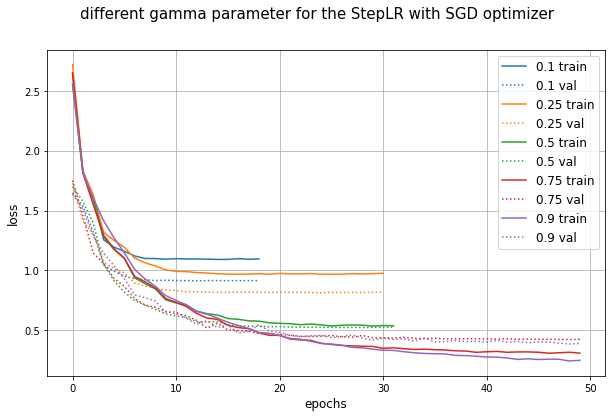

In [84]:
plot_learning_curves(StepLR_gamma_SGD_results, title='different gamma parameter for the StepLR with SGD optimizer')

In [ ]:
# StepLR + ADAM (I didn't have enough to finish this cell)
optimal_ADAMlr = 1e-3
StepLR_gamma_list = [0.1, 0.25, 0.5, 0.75, 0.9]
StepLR_gamma_ADAM_results = {}

for gamma in StepLR_gamma_list:
    model = ResidualConvnet(3, 10).to(device)
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=optimal_ADAMlr) # ADAM
    scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
    results = train_loop2(model, criterion, optimizer, scheduler, train_loader, val_loader, model_name=f'res_ADAM_StepLR_gamma_{gamma}')
    StepLR_gamma_ADAM_results[gamma] = results

with open(path+'StepLR_gamma_ADAM_results.json', 'w') as fp:
    json.dump(StepLR_gamma_ADAM_results, fp)

[EPOCH]: 0, [TRAIN LOSS]: 1.557171, [TRAIN ACCURACY]: 0.440
[EPOCH]: 0, [VAL LOSS]: 1.024920, [VAL ACCURACY]: 0.634 

[EPOCH]: 1, [TRAIN LOSS]: 1.094776, [TRAIN ACCURACY]: 0.612
[EPOCH]: 1, [VAL LOSS]: 0.739835, [VAL ACCURACY]: 0.744 

[EPOCH]: 2, [TRAIN LOSS]: 0.899891, [TRAIN ACCURACY]: 0.685
[EPOCH]: 2, [VAL LOSS]: 0.636157, [VAL ACCURACY]: 0.784 

[EPOCH]: 3, [TRAIN LOSS]: 0.697290, [TRAIN ACCURACY]: 0.762
[EPOCH]: 3, [VAL LOSS]: 0.519315, [VAL ACCURACY]: 0.820 

[EPOCH]: 4, [TRAIN LOSS]: 0.643485, [TRAIN ACCURACY]: 0.779
[EPOCH]: 4, [VAL LOSS]: 0.493632, [VAL ACCURACY]: 0.828 

[EPOCH]: 5, [TRAIN LOSS]: 0.610351, [TRAIN ACCURACY]: 0.791
[EPOCH]: 5, [VAL LOSS]: 0.473006, [VAL ACCURACY]: 0.838 

[EPOCH]: 6, [TRAIN LOSS]: 0.578636, [TRAIN ACCURACY]: 0.803
[EPOCH]: 6, [VAL LOSS]: 0.461450, [VAL ACCURACY]: 0.841 



In [ ]:
plot_learning_curves(StepLR_gamma_ADAM_results, title='different gamma parameter for the StepLR with AMAM optimizer')

### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 

In [24]:
# Load best model
model_path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2/results/Q2/res_SGD_StepLR_gamma_0.9.pt'
model = ResidualConvnet(3, 10).to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
# Evaluate best model on test set
model.eval()
criterion = nn.CrossEntropyLoss(reduction='sum')
with torch.no_grad():
    n_loss = 0.0
    n_correct = 0
    n_samples = 0
    for i, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        loss = criterion(logits, targets)
        predictions = torch.max(logits, dim=1)[1]
        correct = (predictions == targets).sum().item()

        n_loss += loss.item()
        n_correct += correct
        n_samples += targets.size()[0]
    accuracy = n_correct/n_samples
print('The best model is ResidualConvnet using StepLR scheduler with gamma = 0.9 and using SGD optimizer with lr=1e-3')
print("The accuracy of the best model on test set is ", accuracy)

The best model is ResidualConvnet using StepLR scheduler with gamma = 0.9 and using SGD optimizer with lr=1e-3
The accuracy of the best model on test set is  0.8742
